In [42]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [43]:
df = pd.read_csv("kg_triples.tsv", sep="\t", names=["subject", "relation", "object"])

entity_encoder = LabelEncoder()
relation_encoder = LabelEncoder()

entities = list(set(df["subject"]).union(set(df["object"])))
relations = df["relation"]

entity_encoder.fit(entities)
relation_encoder.fit(relations)

edge_index = []
edge_type = []

for _, row in df.iterrows():
    s = entity_encoder.transform([row["subject"]])[0]
    o = entity_encoder.transform([row["object"]])[0]
    r = relation_encoder.transform([row["relation"]])[0]
    edge_index.append([s, o])
    edge_type.append(r)

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_type = torch.tensor(edge_type, dtype=torch.long)
x = torch.eye(len(entity_encoder.classes_))  # One-hot node features

In [44]:
class RGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations):
        super().__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations)

    def forward(self, x, edge_index, edge_type):
        x = self.conv1(x, edge_index, edge_type).relu()
        x = self.conv2(x, edge_index, edge_type)
        return x

In [46]:
model = RGCN(
    in_channels=x.shape[1], 
    hidden_channels=32, 
    out_channels=64, 
    num_relations=len(relation_encoder.classes_)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
losses = []

for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    out = model(x, edge_index, edge_type)
    loss = torch.norm(out[edge_index[0]] - out[edge_index[1]], dim=1).mean()
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 7.5050
Epoch 1, Loss: 3.6972
Epoch 2, Loss: 2.3790
Epoch 3, Loss: 1.7572
Epoch 4, Loss: 1.3349
Epoch 5, Loss: 1.0739
Epoch 6, Loss: 0.8764
Epoch 7, Loss: 0.6924
Epoch 8, Loss: 0.5300
Epoch 9, Loss: 0.4153
Epoch 10, Loss: 0.3352
Epoch 11, Loss: 0.2468
Epoch 12, Loss: 0.1728
Epoch 13, Loss: 0.1113
Epoch 14, Loss: 0.0681
Epoch 15, Loss: 0.0387
Epoch 16, Loss: 0.0236
Epoch 17, Loss: 0.0161
Epoch 18, Loss: 0.0105
Epoch 19, Loss: 0.0060
Epoch 20, Loss: 0.0027
Epoch 21, Loss: 0.0013
Epoch 22, Loss: 0.0008
Epoch 23, Loss: 0.0005
Epoch 24, Loss: 0.0004
Epoch 25, Loss: 0.0004
Epoch 26, Loss: 0.0002
Epoch 27, Loss: 0.0000
Epoch 28, Loss: 0.0000
Epoch 29, Loss: 0.0000
Epoch 30, Loss: 0.0000
Epoch 31, Loss: 0.0000
Epoch 32, Loss: 0.0000
Epoch 33, Loss: 0.0000
Epoch 34, Loss: 0.0000
Epoch 35, Loss: 0.0000
Epoch 36, Loss: 0.0000
Epoch 37, Loss: 0.0000
Epoch 38, Loss: 0.0000
Epoch 39, Loss: 0.0000
Epoch 40, Loss: 0.0000
Epoch 41, Loss: 0.0000
Epoch 42, Loss: 0.0000
Epoch 43, Loss: 0.000

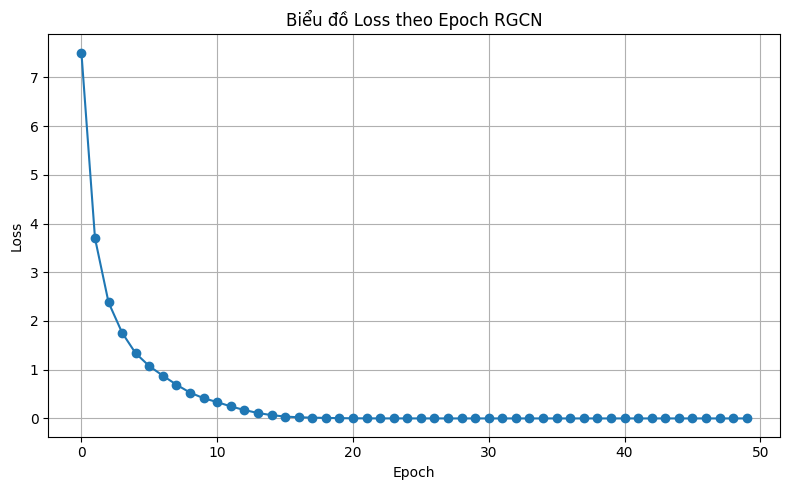

In [48]:
plt.figure(figsize=(8, 5))
plt.plot(range(len(losses)), losses, marker='o')
plt.title("Biểu đồ Loss theo Epoch RGCN")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
def evaluate_rgcn_link_prediction(model, df, entity_encoder, relation_encoder, edge_index, edge_type, x, top_k=[1, 3, 10]):
    model.eval()
    entity_emb = model(x, edge_index, edge_type)

    ranks = []
    hits = {k: 0 for k in top_k}

    for _, row in df.iterrows():
        h, r, t = row["subject"], row["relation"], row["object"]
        try:
            h_idx = entity_encoder.transform([h])[0]
            t_idx = entity_encoder.transform([t])[0]
        except:
            continue

        h_emb = entity_emb[h_idx]
        query = h_emb  # đơn giản, có thể cộng với relation nếu cần

        similarities = F.cosine_similarity(query.unsqueeze(0), entity_emb)
        sorted_indices = torch.argsort(similarities, descending=True)

        rank = (sorted_indices == t_idx).nonzero(as_tuple=True)[0].item() + 1
        ranks.append(rank)

        for k in top_k:
            if rank <= k:
                hits[k] += 1

    mrr = np.mean([1.0 / r for r in ranks])
    mean_rank = np.mean(ranks)

    metrics = {
        "Hits@1": hits[1] / len(ranks),
        "Hits@3": hits[3] / len(ranks),
        "Hits@10": hits[10] / len(ranks),
        "MRR": mrr,
        "Mean Rank": mean_rank
    }
    return metrics

In [50]:
metrics = evaluate_rgcn_link_prediction(
    model=model,
    df=df,
    entity_encoder=entity_encoder,
    relation_encoder=relation_encoder,
    edge_index=edge_index,
    edge_type=edge_type,
    x=x
)

In [51]:
# In kết quả trực tiếp
print("🔍 Đánh giá mô hình:")
print(f"MRR: {metrics['MRR']:.4f}")
print(f"Hits@1: {metrics['Hits@1']:.4f}")
print(f"Hits@3: {metrics['Hits@3']:.4f}")
print(f"Hits@10: {metrics['Hits@10']:.4f}")
print(f"Mean Rank: {metrics['Mean Rank']:.2f}")

🔍 Đánh giá mô hình:
MRR: 0.0635
Hits@1: 0.0036
Hits@3: 0.0304
Hits@10: 0.1411
Mean Rank: 30.87


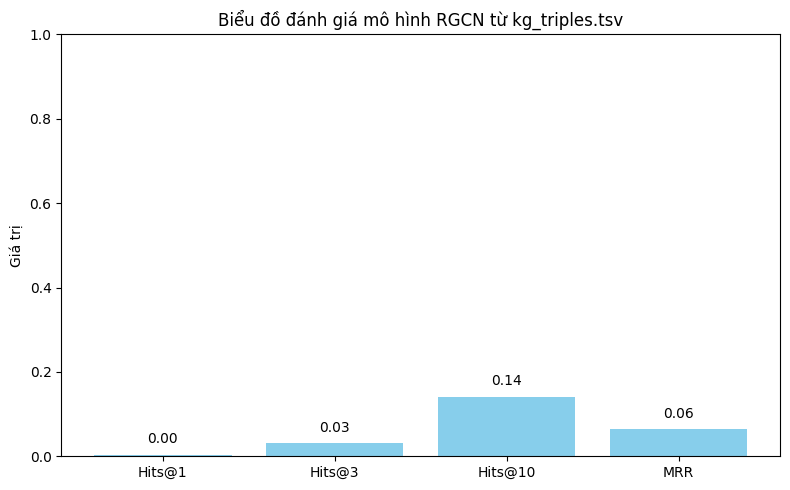

In [53]:
labels = [k for k in metrics if k != "Mean Rank"]
values = [metrics[k] for k in labels]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values, color="skyblue")
plt.ylim(0, 1)
plt.ylabel("Giá trị")
plt.title("Biểu đồ đánh giá mô hình RGCN từ kg_triples.tsv")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f"{yval:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()